In [1]:
!date
!python --version

Thu May 30 01:57:04 AM UTC 2024
Python 3.10.12


# Spacyの基本的な使い方
- 代表的な処理
    - 形態素解析
    - 原形処理
    - カウント
    - 品詞推定
        - [Universal POS tags](https://universaldependencies.org/u/pos/index.html)
    - ストップワード
    - 類義語処理（手動）
    - 用例集
    - n-grams
    - 係り受け推定
        - [Part-of-speech tags and dependencies](https://spacy.io/usage/spacy-101#annotations-pos-deps)
    - 固有表現抽出
    - 分散表現

## 環境構築
ginza, ja_ginza をインストールしておこう。spacyも自動でインストールされます。なお、Google Colabでも実行できますが、この環境は毎回1時間程度立つとリセットされるため、その度にインストールするところからやり直す必要があります。これは手間がかかりますので、なるべくなら自身のPC内に環境構築することをお勧めします。

In [2]:
# spacy, ginzaインストール
!pip install -U ginza ja_ginza

# matplotlib で日本語フォントを使うための環境構築
!pip install japanize-matplotlib

# 以下はこのコードでは使わないが、別例で使う予定のライブラリ
#!pip install networkx # ネットワーク分析
#!pip install pyviz    # グラフ描画ライブラリ。networkxと組み合わせて日本語化対応用。

## 利用ライブラリの用意、データセット準備
事前に、[load_r_assesment.ipynb](./load_r_assesment.ipynb) でデータセットを作成し、pkl形式でファイル保存(r_assesment.pkl)しておく。今回は作成済みファイルをダウンロードして利用することにする。

r_assesment.pklは授業評価アンケートの自由記述欄をpd.DataFrame形式で保存したもので、授業名(title)、学年(grade)、必修か否か(required)、質問番号(q_id)、コメント(comment)で構成される。

In [3]:
!curl -O https://ie.u-ryukyu.ac.jp/~tnal/2022/dm/static/r_assesment.pkl

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 34834  100 34834    0     0  37337      0 --:--:-- --:--:-- --:--:-- 37375


In [4]:
import collections

import numpy as np
import pandas as pd
import spacy

nlp = spacy.load("ja_ginza")

assesment_df = pd.read_pickle('r_assesment.pkl')
assesment_df.head()

,title,grade,required,q_id,comment
0,工業数学Ⅰ,1,True,Q21 (1),特になし
1,工業数学Ⅰ,1,True,Q21 (2),正直わかりずらい。むだに間があるし。
2,工業数学Ⅰ,1,True,Q21 (2),例題を取り入れて理解しやすくしてほしい。
3,工業数学Ⅰ,1,True,Q21 (2),特になし
4,工業数学Ⅰ,1,True,Q21 (2),スライドに書く文字をもう少しわかりやすくして欲しいです。


In [5]:
# 全体像の観察
print('総件数 = ', len(assesment_df))
print('grade内訳: ', collections.Counter(assesment_df['grade']))
print('授業内訳: ', collections.Counter(assesment_df['title']))

print('comment統計情報')
comments_length = [len(comment) for comment in assesment_df['comment']]
pd.Series(comments_length).describe()

総件数 =  170
grade内訳:  Counter({2: 86, 1: 78, 3: 6})
授業内訳:  Counter({'コンピュータシステム': 32, 'プログラミングⅠ': 19, '技術者の倫理': 18, '工業数学Ⅰ': 16, 'アルゴリズムとデータ構造': 15, 'データサイエンス基礎': 15, 'プログラミング演習Ⅰ': 13, '工学基礎演習': 12, 'プロジェクトデザイン': 9, '情報ネットワークⅠ': 7, '情報処理技術概論': 7, '知能情報実験Ⅲ': 3, 'ディジタル回路': 1, 'キャリアデザイン': 1, 'データマイニング': 1, 'ICT実践英語Ⅰ': 1})
comment統計情報


count    170.000000
mean      61.352941
std       61.641492
min        4.000000
25%       21.000000
50%       42.000000
75%       79.750000
max      414.000000
dtype: float64

## spacyによる自然言語処理の全体像
- 参考: [公式ページ:spaCy 101: Everything you need to know](https://spacy.io/usage/spacy-101)
  - [Doc形式](https://spacy.io/api/doc)
  - [Token形式](https://spacy.io/api/token)
  - [Span形式](https://spacy.io/api/span)

<img src="https://spacy.io/images/pipeline.svg">

基本的な使い方は、予め学習済み言語モデルを用意し、用意したモデルに対して文章を与えるだけで一通りの解析を実行してくれる。上図は公式ページのusageから引用したもの。中間部分の青い点線で囲まれている ``nlp`` 部分が解析部分に相当する。用意したnlpに文章を入力すると自動でtagger(品詞推定)、parser(依存関係推定)、ner(固有表現推定)等の処理を一括して行う。解析結果はDoc形式として保存されている。コードで示すと以下のようになる。

```Python
import spacy
nlp = spacy.load('ja_ginza') # 事前学習済みモデルを用意
doc = nlp('今回は自然言語処理ライブラリであるspaCyについて紹介します。') # nlpに文章を入力すると、その戻り値に解析結果が保存される。
```

<img src="https://spacy.io/images/architecture.svg">

上図はspacyによる処理の流れを示している。ここでは以下の流れを把握しよう。
- 上部のText(文章)をnlp(事前学習済み言語モデル)に与えると、赤枠のTokenizer等が実行され、結果が紫枠の[Doc形式](https://spacy.io/api/doc)で保存される。
- Doc形式は[Token形式](https://spacy.io/api/token)もしくは[Span形式](https://spacy.io/api/span)のシーケンスである。シーケンスになっているため、これに対してループ処理を実行することで文頭から文末までのTokenまたはSpanを一つずつ参照することで詳細を確認することができる。
- 分かち書き結果を利用する場合にはTokenを利用する。
- Token単位では扱い難い名詞句や固有表現を利用する場合にはSpanを利用する。

一例をコードで示すと以下のようになる。

```Python
import spacy
nlp = spacy.load('ja_ginza') # 事前学習済みモデルを用意。
doc = nlp('今回は自然言語処理ライブラリであるspaCyについて紹介します。')   # nlpに文章を入力すると、その戻り値に解析結果が保存される。
for token in doc:  # Token単位で処理結果を参照。
  print(token.i, token.lemma_, token.pos_)
```

上記コードを実行すると以下のような結果が得られる。文章が単語に分割されていることを確認しよう。
```
0 今回 NOUN
1 は ADP
2 自然言語処理 ADV
3 ライブラリ ADJ
4 だ AUX
5 ある VERB
6 spacy NOUN
7 に ADP
8 つく VERB
9 て SCONJ
10 紹介 VERB
11 する AUX
12 ます AUX
13 。 PUNCT
```

## 形態素解析による分かち書き
ここでは良く使う機能として分かち書き、原形処理、品詞推定、ストップワードを眺めるとともに、類語をまとめる例について紹介する。それ以外の[Token利用法についてはドキュメントを参照](https://spacy.io/api/token#attributes)しよう。

- case 0: 形態素解析の基本
- case 1: 分かち書き, 原形処理(lemmatize) + カウント
- case 2: 分かち書き, 原形処理 + 品詞別カウント
- case 3: 分かち書き, 原形処理 + ストップワード + 品詞別カウント
- case 4: 分かち書き, 原形処理 + ストップワード + 手動類義語処理 + 品詞別カウント

### case 0: 形態素解析の基本
nlpの解析結果をfor文で順序よく参照する。

In [6]:
# case 0: 形態素解析の基本
#   token.i = 分かち書きされた単語のインデックス
#   token.text = 分かち書きされた単語そのもの
#   token.lemma_ = 単語を原形処理したもの
#   token.pos_ = 品詞推定結果
#   token.dep_ = 係り受け情報
#   token.head.i = 係り受け元単語のインデックス

sample_text = assesment_df['comment'][10]
print(sample_text)

doc = nlp(sample_text)
for token in doc:
    print(token.i, token.text, token.lemma_, token.pos_, token.dep_, token.head.i)

機械トラブルの操作で授業が止まることがあった。
新しいことが学べて大学って感じがした。
0 機械 機械 NOUN compound 1
1 トラブル トラブル NOUN nmod 3
2 の の ADP case 1
3 操作 操作 NOUN obl 7
4 で で ADP case 3
5 授業 授業 NOUN nsubj 7
6 が が ADP case 5
7 止まる 止まる VERB acl 8
8 こと こと NOUN nsubj 10
9 が が ADP case 8
10 あっ ある VERB ROOT 10
11 た た AUX aux 10
12 。 。 PUNCT punct 10
13 
 
 NOUN compound 14
14 新しい 新しい ADJ acl 15
15 こと こと NOUN nsubj 17
16 が が ADP case 15
17 学べ 学べる VERB acl 19
18 て て SCONJ mark 17
19 大学 大学 NOUN advcl 23
20 って って AUX aux 19
21 感じ 感じ NOUN nsubj 23
22 が が ADP case 21
23 し する VERB ROOT 23
24 た た AUX aux 23
25 。 。 PUNCT punct 23


In [7]:
# 品詞、係り受け情報等の用語は spacy.explain で補足情報を確認できる。
# 詳細はドキュメントページ参照。
# Universal POS tags: https://universaldependencies.org/u/pos/index.html
# Part-of-speech tags and dependencies: https://spacy.io/usage/spacy-101#annotations-pos-deps

print(spacy.explain("SCONJ"))
print(spacy.explain("nsubj"))

subordinating conjunction
nominal subject


### case 1: 分かち書き, 原形処理(lemmatize) + カウント
表記上は異なる同一語に活用する語がある。これらを表記によらず同一語として扱うために、原形処理結果(token.lemma_)を処理対象としよう。

In [8]:
# case 1: 分かち書き, 原形処理(lemmatize) + カウント

def count_lemma(df, column):
    '''分かち書き1：原形処理のみ。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
    return
      words_list ([token.lemma_,,,]): 原形処理済み単語のリスト。
    '''
    words_list = []
    for comment in df[column]:
        doc = nlp(comment)
        for token in doc:
            words_list.append(token.lemma_)
    return words_list

words_list = count_lemma(assesment_df, 'comment')
words_count = collections.Counter(words_list)
print(words_count.most_common(10))

[('た', 337), ('の', 310), ('が', 260), ('て', 233), ('。', 231), ('だ', 211), ('、', 193), ('を', 166), ('に', 162), ('と', 147)]


### case 2: 分かち書き, 原形処理 + 品詞別カウント
多くの場合、データの全体像を観察するために処理結果をカウントする。分かち書き結果の場合には多くの文章で共通して現れる助詞が圧倒的多数となってしまうため、直接カウントするだけだとあまり意味のない結果になってしまう。そこで品詞別にカウントしてみることにしよう。

In [9]:
# case 2: 分かち書き, 原形処理 + 品詞別カウント
# 対象品詞
#  名詞(NOUN), 動詞(VERB), 形容詞(ADJ), 副詞(ADV)
# spacyによる品詞一覧: https://universaldependencies.org/u/pos/

def count_lemma2(df, column, target_poses):
    '''分かち書き2：原形処理し、品詞別にカウント。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
      target_poses ([str]): カウント対象となる品詞名のリスト。
    return
      words_dict ({pos1:{token1.lemma_:i, token2.lemma_:j},
                   pos2:{token3.lemma_:k, token4.lemma_:l}}): 品詞(pos)別に、単語をカウント。
    '''
    words_dict = {}
    for pos in target_poses:
        words_dict[pos] = {}

    for comment in df[column]:
        doc = nlp(comment)
        for token in doc:
            if token.pos_ in target_poses:
                if token.lemma_ not in words_dict[token.pos_]:
                    words_dict[token.pos_].update({token.lemma_: 1})
                else:
                    words_dict[token.pos_][token.lemma_] += 1
    return words_dict

target_poses = ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']
words_dict = count_lemma2(assesment_df, 'comment', target_poses)

for pos in target_poses:
    print('pos = ', pos)
    words_count[pos] = collections.Counter(words_dict[pos])
    print(words_count[pos].most_common(10))



pos =  PROPN
[('webclass', 5), ('和田', 2), ('沖縄', 1), ('工学部', 1), ('當間', 1), ('アルゴリズム', 1), ('解決策', 1), ('クソゲー', 1), ('キャンパス', 1), ('github', 1)]
pos =  NOUN
[('こと', 73), ('授業', 44), ('課題', 39), ('試験', 38), ('\r\n', 34), ('講義', 31), ('内容', 22), ('ため', 21), ('問題', 20), ('説明', 19)]
pos =  VERB
[('思う', 68), ('いる', 56), ('ある', 44), ('する', 35), ('なる', 31), ('わかる', 27), ('いう', 21), ('学ぶ', 20), ('できる', 18), ('出す', 17)]
pos =  ADJ
[('良い', 25), ('ない', 24), ('よい', 21), ('多い', 19), ('難しい', 13), ('楽しい', 11), ('非常', 10), ('いい', 9), ('新しい', 6), ('大変', 5)]
pos =  ADV
[('とても', 28), ('特に', 22), ('少し', 14), ('どう', 8), ('今後', 6), ('すぐ', 6), ('もう', 4), ('まだ', 4), ('初めて', 4), ('あまり', 4)]


### case 3: 分かち書き, 原形処理 + ストップワード + 品詞別カウント
品詞別カウントのお陰である程度は概要を掴みやすくなったが、それでも「こと」「ため」「いる」のような頻出語が上位に位置してしまう。見たくない単語（ストップワード）を指定し、削除してしまおう。

In [10]:
# case 3: 分かち書き, 原形処理 + ストップワード + 品詞別カウント
def count_lemma3(df, column, target_poses, stop_words):
    '''分かち書き3：原形処理し、ストップワードを除き、品詞別にカウント。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
      target_poses ([str]): カウント対象となる品詞名のリスト。
      stop_words ([str]): 削除したい単語のリスト。
    return
      words_dict ({pos1:{token1.lemma_:i, token2.lemma_:j},
                   pos2:{token3.lemma_:k, token4.lemma_:l}}): 品詞(pos)別に、単語をカウント。
    '''
    words_dict = {}
    for pos in target_poses:
        words_dict[pos] = {}

    for comment in df[column]:
        doc = nlp(comment)
        for token in doc:
            if token.lemma_ not in stop_words:
                if token.pos_ in target_poses:
                    if token.lemma_ not in words_dict[token.pos_]:
                        words_dict[token.pos_].update({token.lemma_: 1})
                    else:
                        words_dict[token.pos_][token.lemma_] += 1
    return words_dict

target_poses = ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']
stop_words = ['こと', '\r\n', 'ため', '思う', 'いる', 'ある', 'する', 'なる']
words_dict = count_lemma3(assesment_df, 'comment', target_poses, stop_words)

for pos in target_poses:
    print('pos = ', pos)
    words_count[pos] = collections.Counter(words_dict[pos])
    print(words_count[pos].most_common(10))


pos =  PROPN
[('webclass', 5), ('和田', 2), ('沖縄', 1), ('工学部', 1), ('當間', 1), ('アルゴリズム', 1), ('解決策', 1), ('クソゲー', 1), ('キャンパス', 1), ('github', 1)]
pos =  NOUN
[('授業', 44), ('課題', 39), ('試験', 38), ('講義', 31), ('内容', 22), ('問題', 20), ('説明', 19), ('なし', 18), ('資料', 16), ('先生', 15)]
pos =  VERB
[('わかる', 27), ('いう', 21), ('学ぶ', 20), ('できる', 18), ('出す', 17), ('書く', 16), ('ござる', 13), ('つく', 13), ('理解', 12), ('見る', 11)]
pos =  ADJ
[('良い', 25), ('ない', 24), ('よい', 21), ('多い', 19), ('難しい', 13), ('楽しい', 11), ('非常', 10), ('いい', 9), ('新しい', 6), ('大変', 5)]
pos =  ADV
[('とても', 28), ('特に', 22), ('少し', 14), ('どう', 8), ('今後', 6), ('すぐ', 6), ('もう', 4), ('まだ', 4), ('初めて', 4), ('あまり', 4)]


### case 4: 分かち書き, 原形処理 + ストップワード + 手動類義語処理 + 品詞別カウント
名詞別カウントを眺めてみると「授業,44回」「講義,31回」とあるが、これらは同一単語としてカウントしたほうが良いだろう。しかしながら直接spacyでそのように処理することは出来ない。ここではまとめてしまいたい単語群（類義語）とその代表語を手動で用意し、類義語が出現したら代表語に置き換えてしまうことで対処してみよう。

In [11]:
# case 4: 分かち書き, 原形処理 + ストップワード + 手動類義語処理 + 品詞別カウント

def reverse_dict(dict_with_list):
    result = {}
    for k, v_list in dict_with_list.items():
        for v in v_list:
            result[v] = k
    return result

def count_lemma4(df, column, target_poses, stop_words, similar_words):
    '''分かち書き4：原形処理し、ストップワードを除き、類義語を代表語に置き換え、品詞別にカウント。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
      target_poses ([str]): カウント対象となる品詞名のリスト。
      stop_words ([str]): 削除したい単語のリスト。
      similar_words ({similar_word1:representive_word1, similar_word2:representive_word1,,}):
        類義語辞書。keyをvalueに置き換える。
    return
      words_dict ({pos1:{token1.lemma_:i, token2.lemma_:j},
                   pos2:{token3.lemma_:k, token4.lemma_:l}}): 品詞(pos)別に、単語をカウント。
    '''
    words_dict = {}
    for pos in target_poses:
        words_dict[pos] = {}

    for comment in df[column]:
        doc = nlp(comment)
        for token in doc:
            if token.lemma_ not in stop_words:
                if token.lemma_ in similar_words.keys():
                    word = similar_words[token.lemma_]
                else:
                    word = token.lemma_

                if token.pos_ in target_poses:
                    if word not in words_dict[token.pos_]:
                        words_dict[token.pos_].update({word: 1})
                    else:
                        words_dict[token.pos_][word] += 1
    return words_dict

target_poses = ['PROPN', 'NOUN', 'VERB', 'ADJ', 'ADV']
stop_words = ['こと', '\r\n', 'ため', '思う', 'いる', 'ある', 'する', 'なる']
similar_words = {'授業':['講義'], '良い':['よい', 'いい'], 'とても':['特に']}
similar_words = reverse_dict(similar_words)
words_dict = count_lemma4(assesment_df, 'comment', target_poses, stop_words, similar_words)

for pos in target_poses:
    print('pos = ', pos)
    words_count[pos] = collections.Counter(words_dict[pos])
    print(words_count[pos].most_common(10))


pos =  PROPN
[('webclass', 5), ('和田', 2), ('沖縄', 1), ('工学部', 1), ('當間', 1), ('アルゴリズム', 1), ('解決策', 1), ('クソゲー', 1), ('キャンパス', 1), ('github', 1)]
pos =  NOUN
[('授業', 75), ('課題', 39), ('試験', 38), ('内容', 22), ('問題', 20), ('説明', 19), ('なし', 18), ('資料', 16), ('先生', 15), ('お', 14)]
pos =  VERB
[('わかる', 27), ('いう', 21), ('学ぶ', 20), ('できる', 18), ('出す', 17), ('書く', 16), ('ござる', 13), ('つく', 13), ('理解', 12), ('見る', 11)]
pos =  ADJ
[('良い', 55), ('ない', 24), ('多い', 19), ('難しい', 13), ('楽しい', 11), ('非常', 10), ('新しい', 6), ('大変', 5), ('高い', 5), ('必要', 4)]
pos =  ADV
[('とても', 50), ('少し', 14), ('どう', 8), ('今後', 6), ('すぐ', 6), ('もう', 4), ('まだ', 4), ('初めて', 4), ('あまり', 4), ('しっかり', 4)]


### 授業別単語頻出傾向の観察
全コメントを対象とした頻出語は確認できたが、授業毎の違いはないのだろうか。固有名詞(PROPN)と名詞(NOUN)に限定して、授業毎にカウント＆積み上げ棒グラフとして描画してみよう。全体の流れは以下の通りである。

- 頻出語上位20件を用意。
- 授業毎に頻出語が出現した回数をカウント。数えた結果を「単語x授業行列(pd.DataFrame形式)」として整形する。
- pd.DataFrameをmatplotlibで描画する。

#### 頻出語上位20件を用意。

In [12]:
# 講義名のユニーク名一覧
titles = assesment_df['title'].unique()

# 固有名詞＋名詞の上位20単語一覧
top_n = 20
total_words = {**words_dict['PROPN'], **words_dict['NOUN']}
print(len(words_dict['PROPN']), len(words_dict['NOUN']), len(total_words))
top_n_words = collections.Counter(total_words).most_common(top_n)
top_n_words

10 425 434


[('授業', 75),
 ('課題', 39),
 ('試験', 38),
 ('内容', 22),
 ('問題', 20),
 ('説明', 19),
 ('なし', 18),
 ('資料', 16),
 ('先生', 15),
 ('お', 14),
 ('難易度', 12),
 ('解答', 11),
 ('実際', 11),
 ('方', 10),
 ('テスト', 10),
 ('知識', 9),
 ('機会', 9),
 ('生徒', 9),
 ('中間', 9),
 ('期末', 9)]

#### 授業毎に頻出語が出現した回数をカウント。

In [13]:
# 授業別に top_n_words が出現した回数をカウント
words = [k for k,v in top_n_words]
zero_matrix = np.zeros((len(words), len(titles)), dtype=int)
df_title_vs_word = pd.DataFrame(zero_matrix, columns=titles, index=words)

# 授業別にコメントを前処理しておく
title_comments = {}
for title in titles:
    comments = assesment_df[assesment_df['title'] == title]['comment']
    tokens = []
    comments = ' '.join(comments)
    doc = nlp(comments)
    for token in doc:
        if token.pos_ == 'PROPN' or token.pos_ == 'NOUN':
            if token.lemma_ in words:
                df_title_vs_word.loc[token.lemma_, title] += 1

df_title_vs_word

,工業数学Ⅰ,技術者の倫理,工学基礎演習,プログラミングⅠ,プログラミング演習Ⅰ,アルゴリズムとデータ構造,情報ネットワークⅠ,コンピュータシステム,データサイエンス基礎,ディジタル回路,情報処理技術概論,プロジェクトデザイン,キャリアデザイン,データマイニング,ICT実践英語Ⅰ,知能情報実験Ⅲ
授業,3,3,2,0,1,2,1,19,4,1,2,5,0,0,0,1
課題,2,0,0,6,3,0,0,23,3,0,0,1,0,1,0,0
試験,0,0,0,0,0,3,0,29,4,0,2,0,0,0,0,0
内容,0,2,0,1,0,2,0,12,4,0,0,1,0,0,0,0
問題,1,0,0,0,0,4,0,12,2,0,1,0,0,0,0,0
説明,2,0,0,2,0,3,0,7,2,1,1,0,0,0,0,1
なし,3,4,4,4,3,0,0,0,0,0,0,0,0,0,0,0
資料,0,0,0,0,0,3,1,8,0,1,2,1,0,0,0,0
先生,0,3,0,1,0,1,0,6,2,0,1,0,1,0,0,0
お,1,2,0,2,1,0,3,4,1,0,0,0,0,0,0,0


#### 積み上げ棒グラフ1

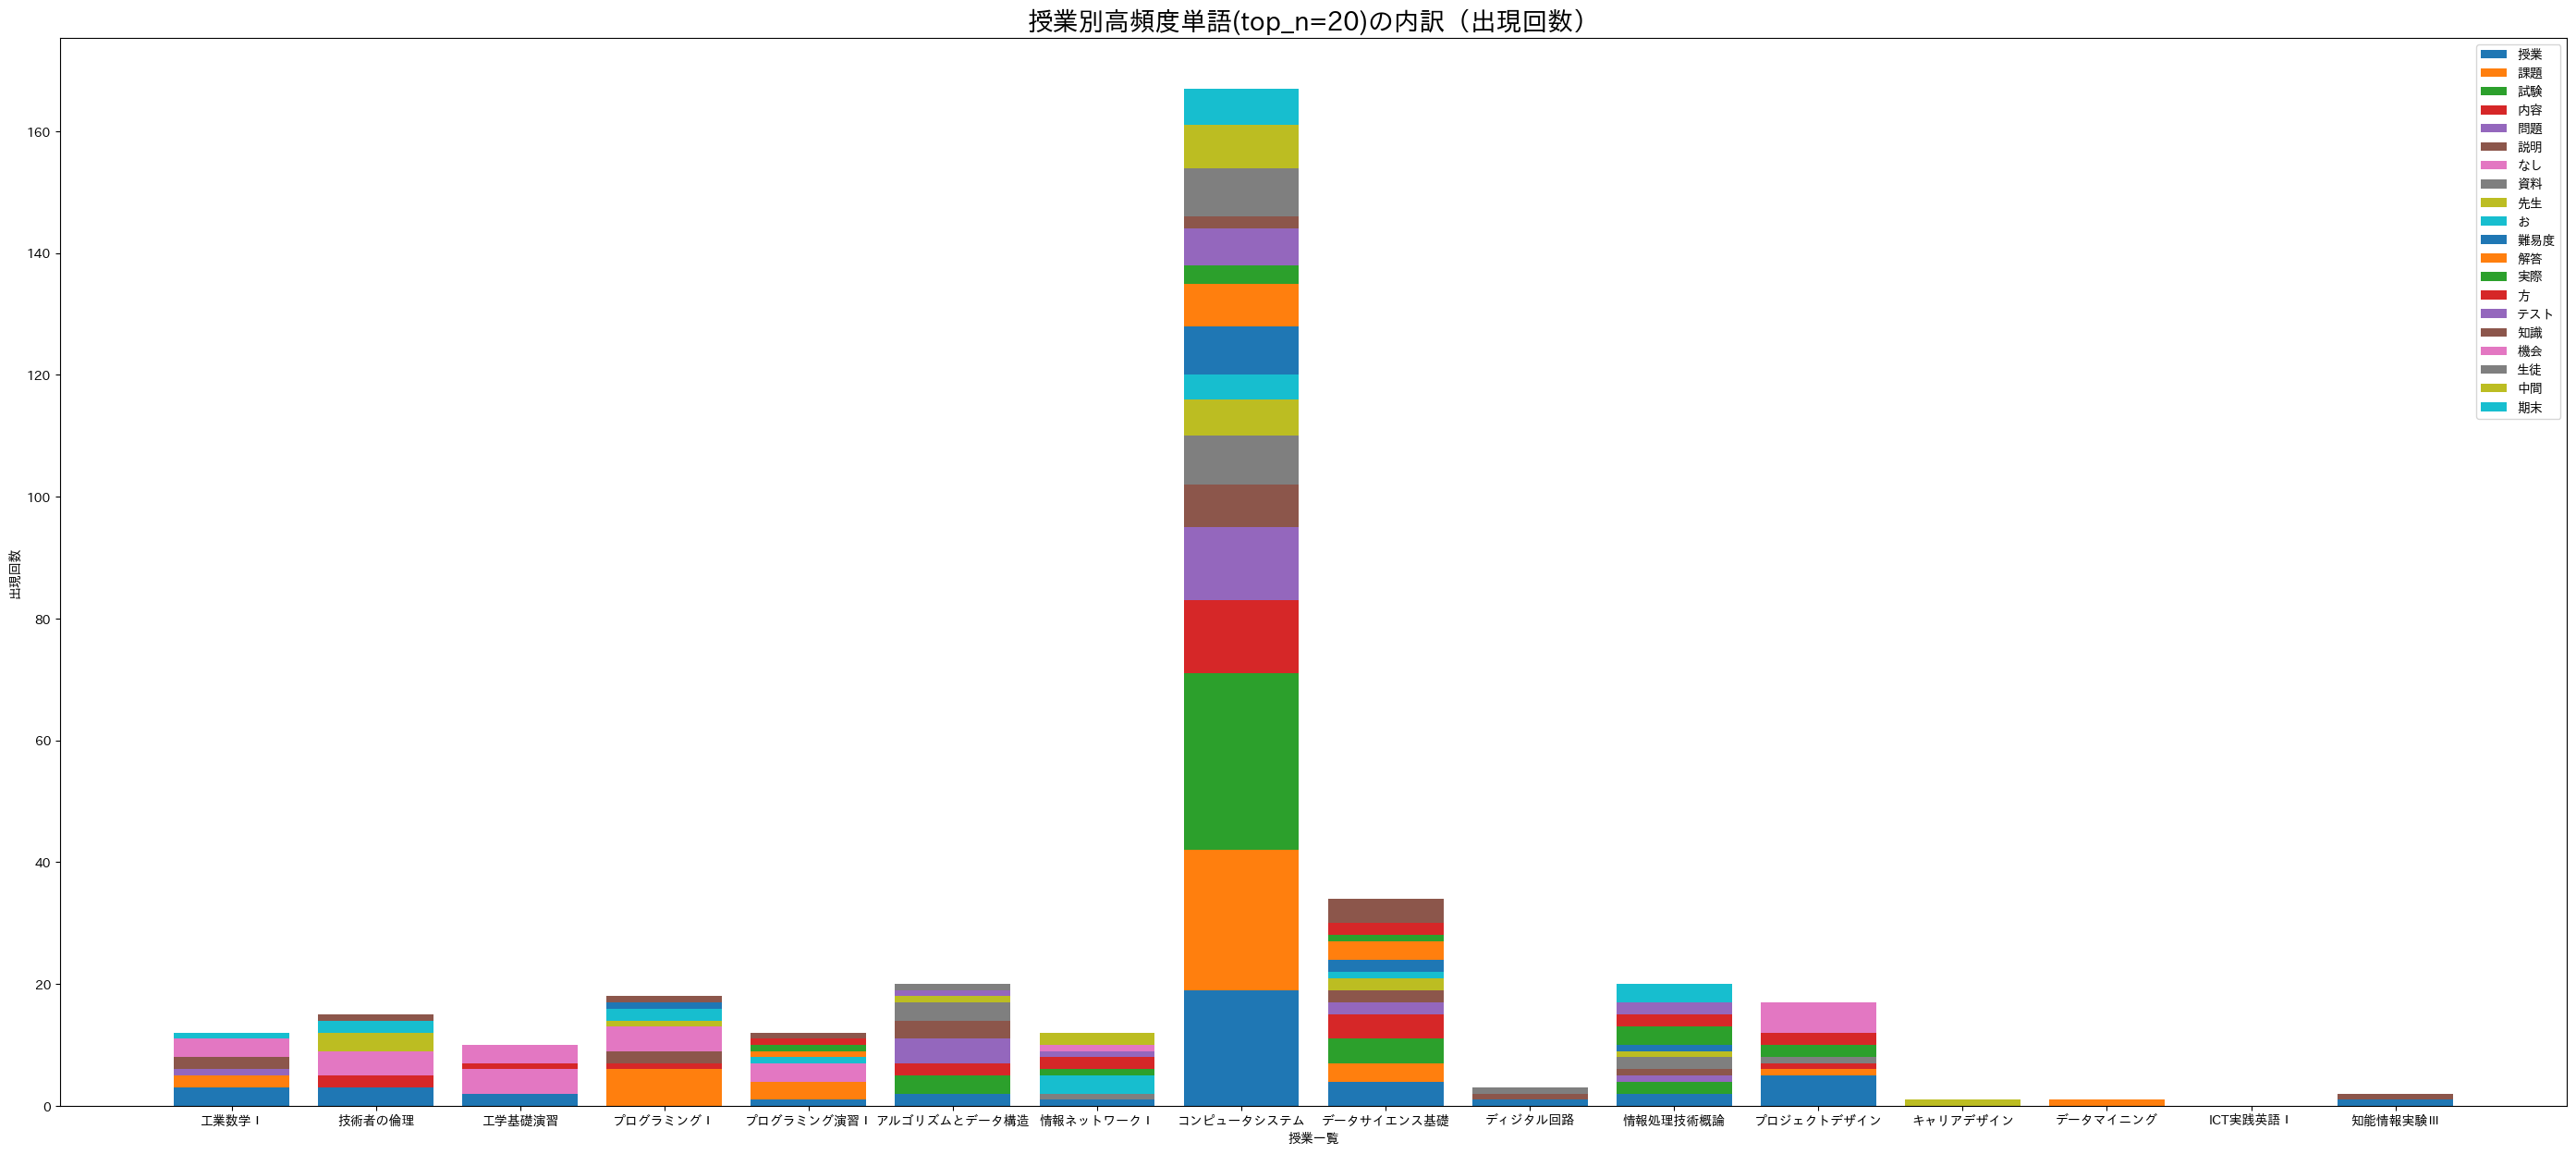

In [14]:
import matplotlib.pyplot as plt
import japanize_matplotlib

fig, ax = plt.subplots(figsize=(35, 15))
for i in range(len(df_title_vs_word)):
    ax.bar(df_title_vs_word.columns, df_title_vs_word.iloc[i], bottom=df_title_vs_word.iloc[:i].sum())

ax.legend(df_title_vs_word.index)
ax.set_title(f'授業別高頻度単語(top_n={top_n})の内訳（出現回数）', size=20)
ax.set_xlabel('授業一覧')
ax.set_ylabel('出現回数')
plt.show()

#### 積み上げ棒グラフ2（横）
縦に積み上げる形式（ax.bar）だと確認しづらいので、横方向に積み上げ（ax.barh）よう。

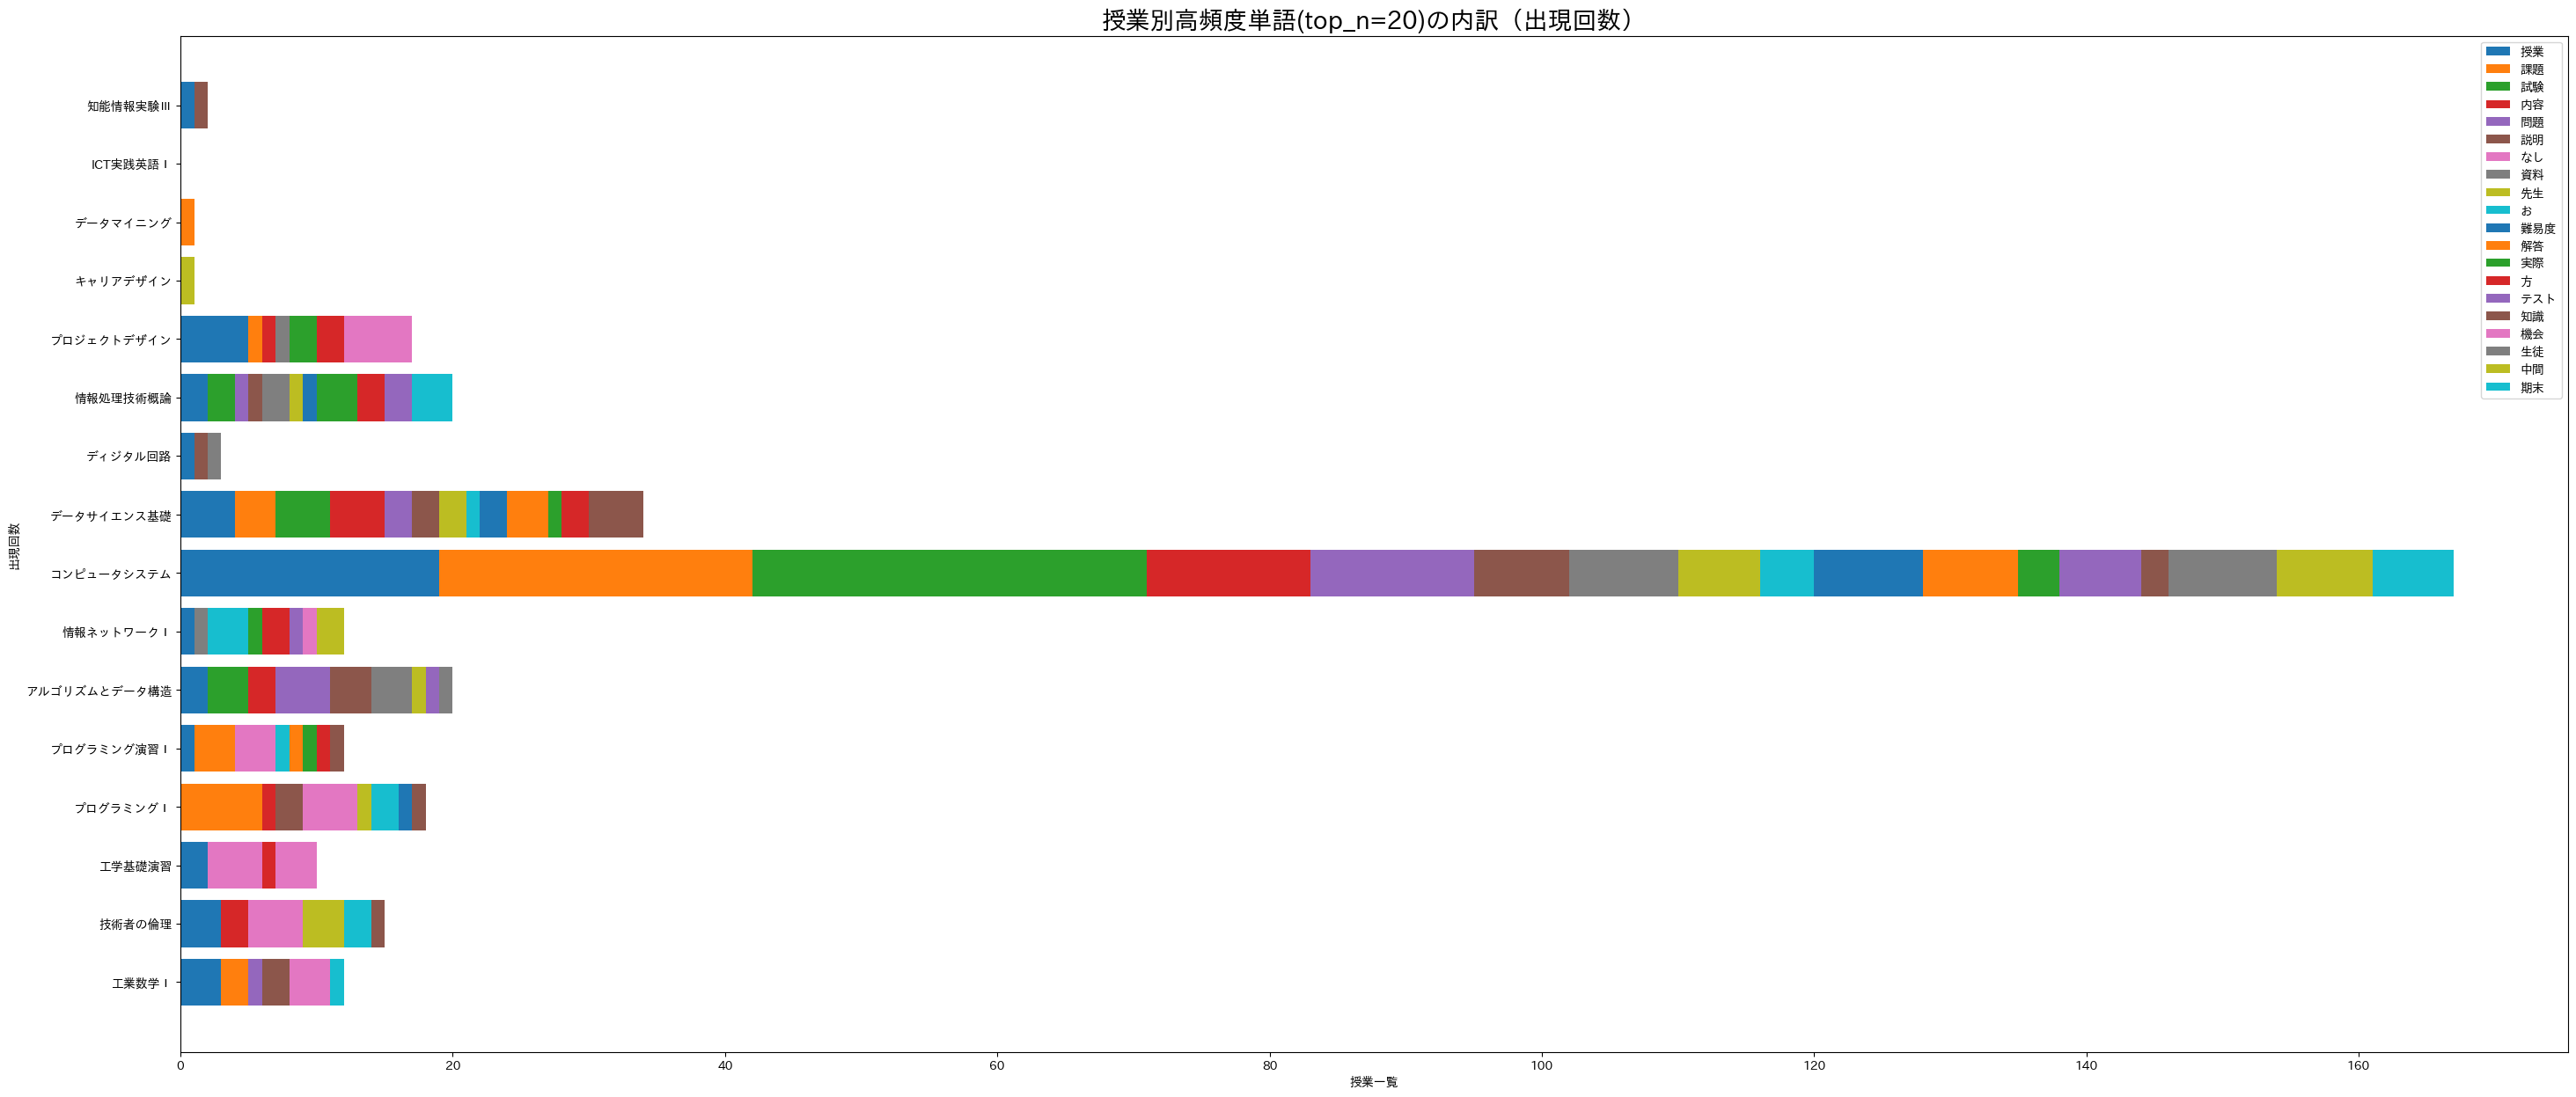

In [15]:
fig, ax = plt.subplots(figsize=(35, 15))
for i in range(len(df_title_vs_word)):
    ax.barh(df_title_vs_word.columns, df_title_vs_word.iloc[i], left=df_title_vs_word.iloc[:i].sum())

ax.legend(df_title_vs_word.index)
ax.set_title(f'授業別高頻度単語(top_n={top_n})の内訳（出現回数）', size=20)
ax.set_xlabel('授業一覧')
ax.set_ylabel('出現回数')
plt.show()

#### 積み上げ棒グラフ3（横+正規化）
一部の授業が突出しているため他の傾向を掴みづらい。出現回数をそのまま扱うのではなく、授業毎の出現割合に変換してから描画してみよう。

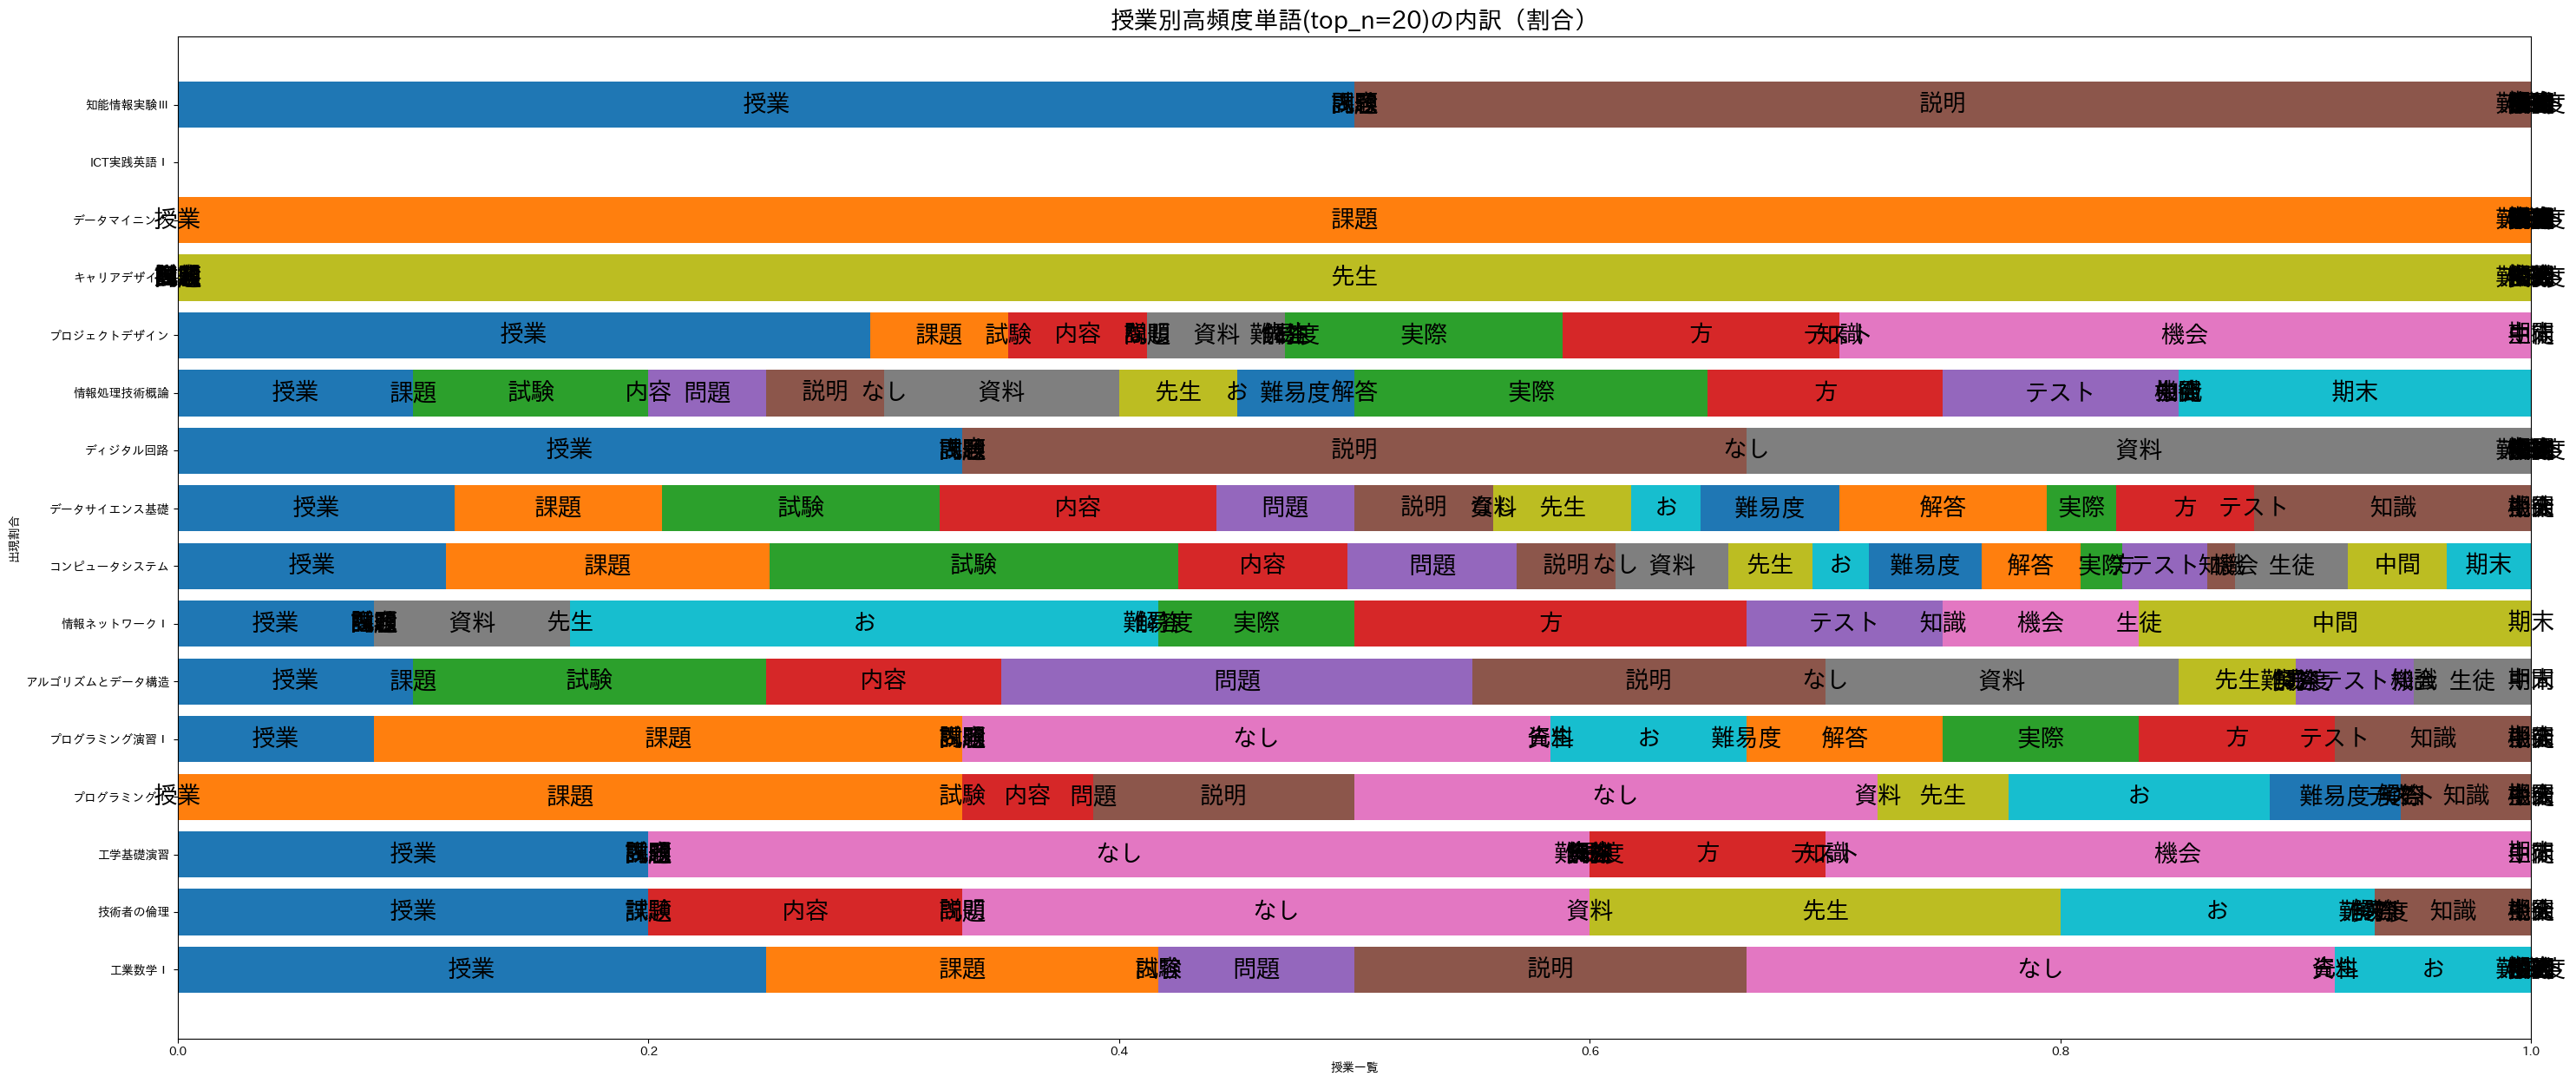

In [16]:
normalize_df = df_title_vs_word.div(df_title_vs_word.sum(axis=0), axis=1)

fig, ax = plt.subplots(figsize=(35, 15))
for i in range(len(df_title_vs_word)):
    bar = ax.barh(normalize_df.columns, normalize_df.iloc[i], left=normalize_df.iloc[:i].sum())
    for rect in bar:
        center_x = rect.get_x() + rect.get_width() / 2
        center_y = rect.get_y() + rect.get_height() / 2
        if np.isnan(center_x) == False and np.isnan(center_y) == False:
            ax.text(center_x, center_y, normalize_df.index[i], ha='center', va='center', size=20)

ax.set_title(f'授業別高頻度単語(top_n={top_n})の内訳（割合）', size=20)
ax.set_xlabel('授業一覧')
ax.set_ylabel('出現割合')
#ax.legend(normalize_df.index)
plt.show()


#### 積み上げ棒グラフ（横＋正規化＋色調整）
一部の色が被っていて誤解してしまう。標準では10色までしか用意されておらず、使い終えると再び同じ色が利用されるようだ。これを避けるために[colormap](https://matplotlib.org/3.5.0/tutorials/colors/colormaps.html)を指定して色重複されないようにしよう。

<ipython-input-17-658c67e06614>:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cm = plt.cm.get_cmap('tab20')


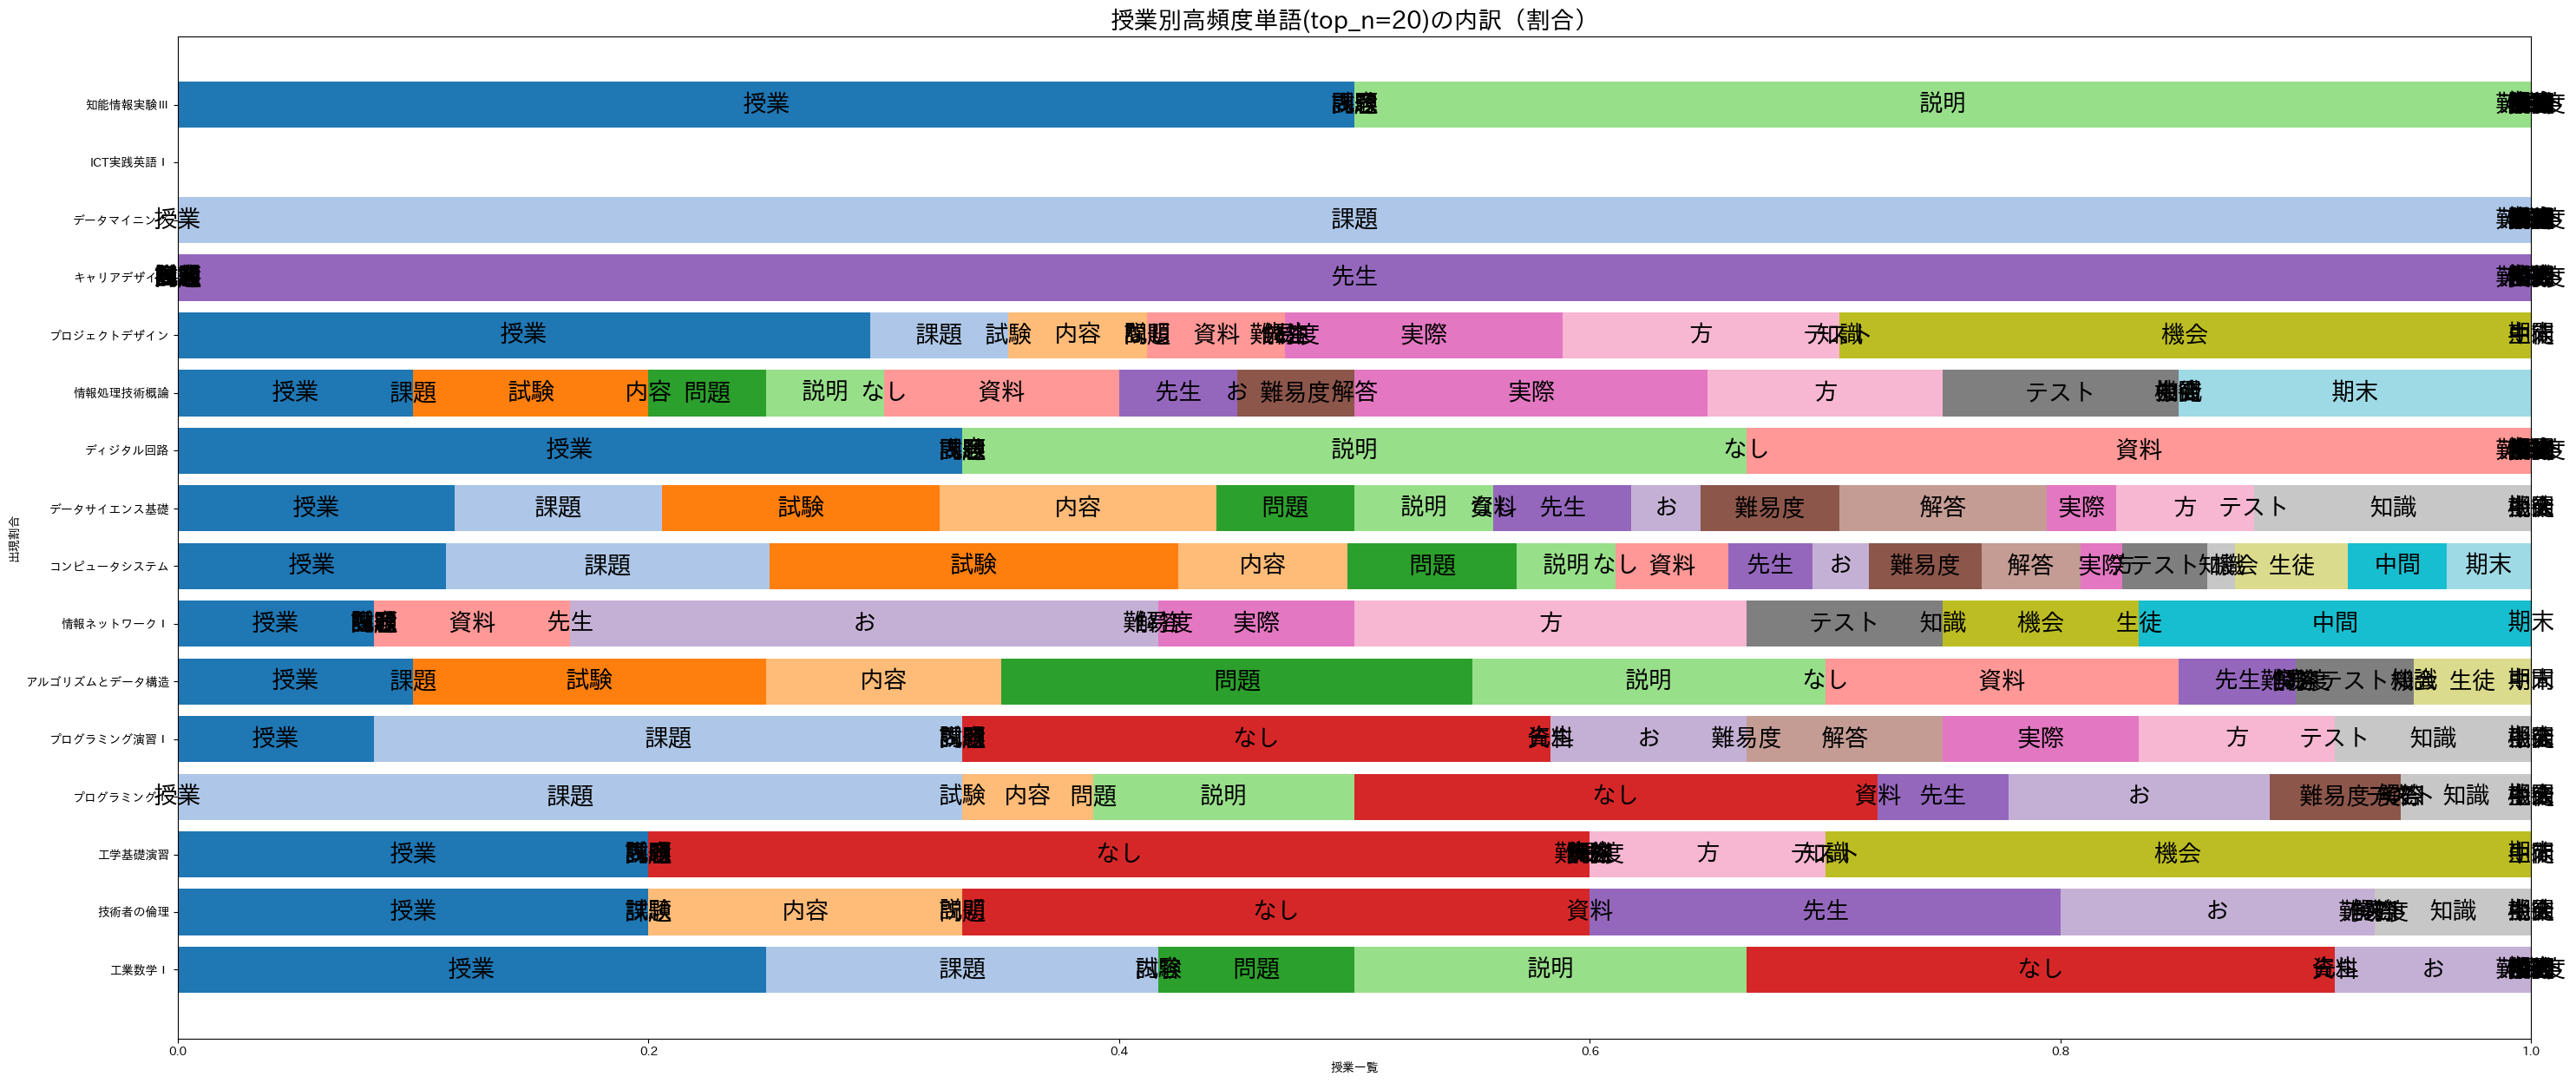

In [17]:
normalize_df = df_title_vs_word.div(df_title_vs_word.sum(axis=0), axis=1)

fig, ax = plt.subplots(figsize=(35, 15))
cm = plt.cm.get_cmap('tab20')
for i in range(len(df_title_vs_word)):
    bar = ax.barh(normalize_df.columns, normalize_df.iloc[i], left=normalize_df.iloc[:i].sum(), color=cm.colors[i])
    for rect in bar:
        center_x = rect.get_x() + rect.get_width() / 2
        center_y = rect.get_y() + rect.get_height() / 2
        if np.isnan(center_x) == False and np.isnan(center_y) == False:
            ax.text(center_x, center_y, normalize_df.index[i], ha='center', va='center', size=20)

ax.set_title(f'授業別高頻度単語(top_n={top_n})の内訳（割合）', size=20)
ax.set_xlabel('授業一覧')
ax.set_ylabel('出現割合')
#ax.legend(normalize_df.index)
plt.show()


## 用例集
「ござる」？？　これを含む文例を探してみよう。[pd.Series.str.contains](https://pandas.pydata.org/docs/reference/api/pandas.Series.str.contains.html)を使えば良いだけなんだけど、微妙に使いづらいので関数として用意してみる。

In [18]:
def get_examples(df, column, text):
    return df[df[column].str.contains(text)][column]

#assesment_df['comment'].str.contains('例題')
df = get_examples(assesment_df, 'comment', 'ござ')
df

14     新しく触れる分野だったので不安はあったのですが、自分なりに解釈して理解することができたと思い...
31     良い技術者になるためには、道徳の分野が重要だということがわかりました。和田先生の講義内容は私...
44     この講義のおかげで、周りの人と話すことができたのでとてもよかったです。この講義がなければ私は...
64     私は今までプログラミングに触れたことがなかったので新しいことを覚えるのに必死でした。ですが、...
75     最初はターミナルの使い方すら分からなくてとても焦りました。ですが、コマンドやコードの意味、書...
90                                           ありがとうございました
97     企業の方を招待してお話を聞かせていただいてありがとうございました。とてもためになるお話が聞け...
141    講義を通して、確率統計に関する知識を獲得することができたと思います。これらの知識を利用して個...
145                               とても良かったです．ありがとうございました．
152    実際にIT機器や技術がどのように使われているかを学ぶことができて良かったです。\r\nありが...
159    CM楽しかったです。実際に講義で学んだ手法を使うと、スムーズにグループワーク ができることを...
165    課題が難しいものが多く、時間を多くとってもらえたのは非常に良かったですがかなりきつかったです...
Name: comment, dtype: object

## n-gramsを利用した用例検索
個々の単語をカウントして上位確認することでおおよその概要を掴みやすくなった。しかしこれだけだと複数の連続語として出現しやすい表現（フレーズ）や、同時に現れやすい単語（共起語）については把握しづらい。

このような複数語を観察しやすくする一つの方法として **n-gram** で観察してみよう。n-gramとは、「n個の連続した単語」を特徴として扱う考え方であり、これまでの「個々の単語を独立してカウント」していたものは ``1-gram`` に相当する。n=2の ``2-gram（bi-gramとも呼ばれる）`` ならば「2個の連続した語」を基本特徴とする。何個まで考慮するかはケース・バイ・ケースである。増やすほどより細かな特徴を対象とすることが可能だが、それだけ処理が重くなってしまうため多くの場合は2〜5-gramに留めることが多いかもしれない。例として2007年にGoogleにより公開された[大規模日本語n-gramデータ](https://japan.googleblog.com/2007/11/n-gram.html)では1〜7-gramまで対応している。より大規模な英語コーパスに対しては[Google Books Ngram Viewer](https://books.google.com/ngrams)として1〜5-gramまで対応しており、こちらは品詞指定なども可能となっている。

ここではn-gramを自前で解析してみよう。

In [19]:
def count_ngrams(df, column, n=3):
    '''分かち書き4：原形処理し、ストップワードを除き、類義語を代表語に置き換え、品詞別にカウント。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
      n (int): n-gramとしてカウントする連続語数n。
    return
      result ({n_gram_text:count}): 出現したn-gram毎の出現回数を保持した辞書。
    '''
    if n <= 1:
        return None

    stop_words = ['', '\r\n']
    result = {}
    for comment in df[column]:
        doc = nlp(comment)
        token_list = []
        for token in doc:
            if token.lemma_ not in stop_words:
                token_list.append(token.lemma_)

        if len(token_list) < n:
            pass

        for index in range(len(token_list)-n+1):
            ngram = ' '.join(token_list[index:index+n]) # n-gramをスペース区切り文字列として用意
            if ngram not in result:
                result[ngram] = 1
            else:
                result[ngram] += 1
    return result

ngrams = count_ngrams(assesment_df, 'comment', 3)
ngrams_count = collections.Counter(ngrams)
ngrams_count.most_common(10)

[('と 思う ます', 46),
 ('た の だ', 38),
 ('ます た 。', 37),
 ('思う ます 。', 35),
 ('た です 。', 30),
 ('た と 思う', 28),
 ('こと が できる', 21),
 ('です が 、', 17),
 ('が できる た', 16),
 ('の だ 、', 15)]

In [20]:
def filter_dict(ngrams_count_dict, text):
    '''指定した語を含むngramを検索。
    args:
      ngrams_count_dict (dict): count_ngrams()で作成したn-gram解析結果の辞書。
      text (str): 検索語。
    '''
    return dict(filter(lambda item: text in item[0], ngrams_count_dict.items()))

examples = filter_dict(ngrams_count, 'ござ')
examples_count = collections.Counter(examples)
examples_count.most_common(10)

[('ありがとう ござる ます', 13),
 ('ござる ます た', 13),
 ('。 ありがとう ござる', 7),
 ('くださる ありがとう ござる', 2),
 ('話 ありがとう ござる', 1),
 ('て ありがとう ござる', 1),
 ('. ありがとう ござる', 1)]

## 係り受け情報を利用した検索
n-gramはn個の連続した語、もしくはその範疇にある共起語に対してはうまく機能する。nを増やせば理論的にはあらゆる共起を参照できるが計算コスト的には現実的ではない上に「共起＝それらの語が密接に結びついている」とは限らないこともある。

例えば「授業用スライドが丁寧に作られていてわかりやすかった。」という文を例に上げると、わかりやすかったのは「授業」もしくは「授業用スライド」だろう。このような関係は係り受け構造を考慮した方が良い。しかしながら係り受け関係は複雑であり、全てを網羅して処理するのは苦労する。例えば今回の例では aux, mark が出現する。これらは補助的に使われる関係（Non-core dependents）であり、主要な情報ではない。実際「作る」に係る関係のうち、auxは「に」、markは「て」であり、今回の共起語としては扱いたくない。そこで以下の例では「使いたくない関係を指定」した上で抽出するとしよう。

- 参考
  - [Universal Dependencies](https://universaldependencies.org), spacyで採用している汎用(言語を問わない)係り受け関係。
  - [Universal Dependency Relations](https://universaldependencies.org/u/dep/), 係り受けタグの一覧。

In [21]:
from spacy import displacy

doc = nlp(assesment_df['comment'][13])
displacy.render(doc, style="dep", options={"compact":True})

In [22]:
# 係り受け情報の確認
doc = nlp(assesment_df['comment'][13])
for token in doc:
    print(token.i, token.text, token.dep_, token.head.i)

0 授業 compound 2
1 用 compound 2
2 スライド nsubj 6
3 が case 2
4 丁寧 advcl 6
5 に aux 4
6 作ら advcl 11
7 れ aux 6
8 て mark 6
9 い fixed 8
10 て mark 6
11 わかり ROOT 11
12 やすかっ aux 11
13 た aux 11
14 。 punct 11


In [23]:
# 指定単語に係る元の単語を探してみる

def find_pre_token(text, target_word, deps=['aux', 'mark']):
    '''指定単語に係る元の単語集合を探す。ただし特定関係は除外する。
    args:
      text (str): 解析対象文。
      target_word (str): 指定単語。
      deps ([str]): 除外したい係り受け関係。
    return
      result ([str]): target_wordに係る単語のリスト。
    '''

    # 係り受け情報を保存
    doc = nlp(text)
    dependencies = {}
    for token in doc:
        dependencies.update({token.i:[token.text, token.dep_, token.head.i]})
        if token.text == target_word:
            target_index = token.i # 検索語のインデックス

    # 係り受け元探し
    result = []
    for key, value in dependencies.items():
        if value[2] == target_index:
            if value[1] not in deps:
                result.append(value[0])
    return result

text = assesment_df['comment'][13]
pre_tokens = find_pre_token(text, '作ら')
pre_tokens

['スライド', '丁寧']

## 固有表現抽出
場所や人名、日付、時間等の特定対象を指す表現を固有表現 (Named Entity) と呼ぶ。実際の定義はツール毎に異なる点に注意。
- 参考: [Wikipedia:固有表現抽出](https://ja.wikipedia.org/wiki/固有表現抽出)

In [24]:
for comment in assesment_df['comment']:
    doc = nlp(comment)
    for entity in doc.ents:
        print(entity.text, entity.label_)

一度 Frequency
3つ Countx_Other
１ずつ N_Product
１年次 Countx_Other
線形代数 Academic
線形代数 Academic
第２Q Ordinal_Number
コロナ Company
教授 Position_Vocation
COVID１９ Product_Other
沖縄 Province
技術者 Position_Vocation
和田 Person
先生 Position_Vocation
和田 Person
先生 Position_Vocation
先生 Position_Vocation
4年間 Period_Year
1Q Pro_Sports_Organization
社会人 Position_Vocation
企業人インタビュー Position_Vocation
工学部 Organization_Other
7つ Countx_Other
一つ Countx_Other
ネット Doctrine_Method_Other
プログラミングII Game
夏休み Date
２学期 Date
GOOD Dish
一人 N_Person
當間 Person
先生 Position_Vocation
１週間 Period_Week
２週間 Period_Week
プログラミング１ Game
コロナ Company
黄色 Nature_Color
先生 Position_Vocation
生徒 Position_Vocation
成績評価 Position_Vocation
２週 Period_Year
先生 Position_Vocation
webclass Person
webclass Person
1ページ Countx_Other
4枚 N_Product
1ページ N_Product
1枚 N_Product
1ページ Countx_Other
4枚分 N_Product
先生 Position_Vocation
mattermost Food_Other
生徒 Position_Vocation
先生 Position_Vocation
先生 Position_Vocation
生徒 Position_Vocation
1ページ N_Product
4分割 Percent
頭 Animal_

## 単語の特徴ベクトル（分散表現）
分かち書きされたTokenを対象として処理する際の問題の一つに、単語表記を元にした処理をしようとした際の柔軟性が低いことがあげられる。例えば類義語処理においては「授業」と「講義」を同一視するために直接それらを列挙する必要があった。実際問題として手動でやる手間をゼロにすることは困難だが、ある程度の自動化については[分散表現](https://ledge.ai/word2vec/)が機能しつつある。分散表現の詳細は後日扱うとして、ここでは「単語の意味をベクトルとして表現する」ぐらいに捉え、実例を眺めてみよう。

In [25]:
# ja_ginza (5.1.0) の標準モデルでは2万6千語が300次元のベクトルとして登録されている。
# Transformersモデルとして構築し直された ja_ginza_electra は ja_ginzaよりも高精度だが、
# メモリ16GB以上が必要だ。

nlp.vocab.vectors.shape

(26000, 300)

### tokenやdocからベクトルを得る
単にベクトルを得るだけならば、nlpで解析後に doc.vector や token.vectorとするだけで得られる。

In [26]:
text = assesment_df['comment'][0]
doc = nlp(text)
print(doc.vector.shape)
print(doc.vector[:5]) # 冒頭5次元目まで

(300,)
[ 0.03997449 -0.12051773 -0.04468929 -0.12576343 -0.11509937]


In [27]:
for token in doc:
    print(token.text, token.vector[:5])

特に [ 0.19660935 -0.06194177  0.00594446 -0.23807472 -0.10820279]
なし [-0.11666037 -0.17909369 -0.09532304 -0.01345213 -0.12199596]


### 直接単語や文章からベクトルを得る
nlpで解析せずとも、内部モデルからベクトルを参照することも可能。ただし単語を直接指定するのではなく、``nlp.vocab.strings('単語')`` により単語のハッシュ値を求め、そのハッシュ値に対応するベクトルを参照するという手順を踏む必要がある。

In [28]:
print(nlp.vocab.strings['特に'])
word_vector = nlp.vocab.vectors[nlp.vocab.strings['特に']]
print('特に => ', word_vector[:5])

4452343185052482328
特に =>  [ 0.19660935 -0.06194177  0.00594446 -0.23807472 -0.10820279]


### 類似語を探してみる
今回のコメント一覧だけを対象として類似語参照してみよう。

In [29]:
def get_uniq_token(df, column):
    '''ユニークなTokenのみを収集。
    args:
      df (pd.DataFrame): 読み込み対象データフレーム。
      column (str): データフレーム内の読み込み対象列名。
    return
      uniq_tokens ([token]): ユニークTokenのリスト。
      uniq_words ([token.lemma_]): ユニークToken.lemma_のリスト。
    '''
    uniq_tokens = []
    uniq_words = []
    for comment in df[column]:
        doc = nlp(comment)
        for token in doc:
            if token.lemma_ not in uniq_words:
                uniq_tokens.append(token)
                uniq_words.append(token.lemma_)
    return uniq_tokens, uniq_words

uniq_tokens, uniq_words = get_uniq_token(assesment_df, 'comment')
print(len(uniq_tokens), len(uniq_words))
print(uniq_tokens[:5], uniq_words[:5])
print(type(uniq_tokens[0]), type(uniq_words[0]))

914 914
[特に, なし, 正直, わかり, ずらい] ['特に', 'なし', '正直', 'わかる', 'ずらい']
<class 'spacy.tokens.token.Token'> <class 'str'>


In [30]:
from sklearn.metrics.pairwise import cosine_similarity

def calc_similarity_matrix(tokens):
    '''トークン同士の類似度（コサイン類似度）を計算。
    args:
      tokens ([token]): トークン一覧のリスト。
    return
      result ([[similarity1, similarity2,,,],,,]): トークン同士の類似度行列。
    '''
    target_vectors = [token.vector for token in tokens]
    result = cosine_similarity(target_vectors, target_vectors)
    return result

similarity_matrix = calc_similarity_matrix(uniq_tokens)

print(uniq_tokens[:3])
for i in range(3):
    print(uniq_tokens[i], end='')
    for j in range(3):
        print(similarity_matrix[i][j], end=', ')
    print()


[特に, なし, 正直]
特に1.0000002, 0.4533139, 0.5239588, 
なし0.4533139, 0.99999976, 0.39796996, 
正直0.5239588, 0.39796996, 1.0000001, 


In [31]:
def most_similar(similarity_matrix, tokens, words, word, n=3):
    '''類似度行列から指定単語と類似している単語上位n個を出力。
    args:
      similarity_matrix: calc_similarity_matrix()で算出した類似度行別。
      tokens ([token]): ユニークなトークンのリスト。
      words ([word]): ユニークな単語のリスト。
      word (str): 検索対象語。
      n (int): 出力件数。
    return
      None
    '''
    word_index = words.index(word)
    similar_indices = np.argsort(similarity_matrix[word_index])[::-1][:n]
    print(similar_indices)

    for i in range(n):
        target_index = similar_indices[i]
        print(tokens[target_index].lemma_, similarity_matrix[word_index][target_index])

most_similar(similarity_matrix, uniq_tokens, uniq_words, '授業', n=5)

[ 71 551 736  54 847]
授業 1.0000001
板書 1.0000001
自学 1.0000001
講義 0.8029713
学校 0.7283687
